# SWOT



In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv
from holoviews import opts
import matplotlib as mpl
import numpy as np

hv.extension('bokeh')

<Axes: >

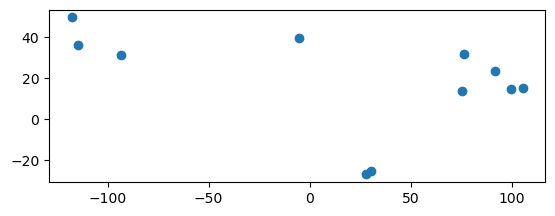

In [2]:
# read the} bounding box of the study area
val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation-pts.geojson'))
val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
    '1078' # Lake Mead, US
]
res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca',
    '1078': 'Lake Mead, US'
}

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [3]:
start_date = '2022-01-01'
end_date = '2024-06-27'
RESERVOIR = '1078'
buffer_amt = 1000 # meters
RESERVOIR_NAME = res_names[RESERVOIR]
print(f'{RESERVOIR}: {RESERVOIR_NAME}')

1078: Lake Mead, US


<Axes: >

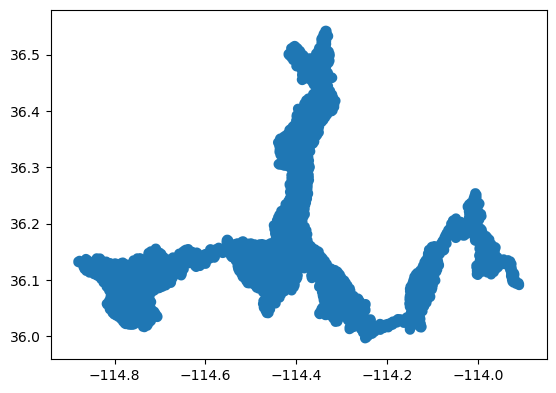

In [4]:
roi = val_res_poly[val_res_poly['tmsos_id']==RESERVOIR]
utm_crs = roi.estimate_utm_crs()
buffered_roi_utm = roi.to_crs(utm_crs).geometry.buffer(buffer_amt)
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')
buffered_roi.plot()

## SWOT - determine pass number

<Axes: >

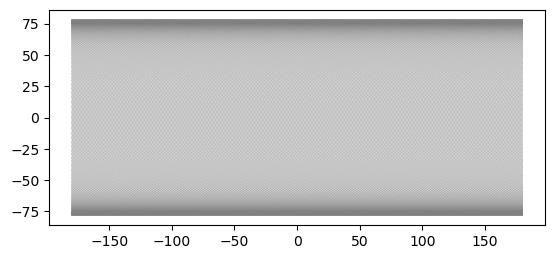

In [5]:
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)
gd_track.plot(facecolor='none', edgecolor='gray', lw=0.1, alpha=0.7)

In [6]:
gd_track_subset = gd_track[gd_track.intersects(buffered_roi.geometry.values[0])]

roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME
roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]
tracks_hv = gd_track_subset.hvplot(
    geo=True, tiles='OSM', color=gd_track_subset['color'], alpha=0.5, line_width=2,
    xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
    ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
    tools=['hover'], hover_cols=['ID_PASS']
)

(tracks_hv * roi_hv).opts(
    title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
)

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (_color,ID_PASS)
   .Polygons.II :Polygons   [Longitude,Latitude]

In [14]:
matches = gd_track[gd_track.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
pass_ids = list(matches.ID_PASS)
print(f'Passes: {pass_ids}')

Passes: [205, 218, 496, 511]


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from tmsswot.data import download_swot_for_reservoir

swot_save_dir = Path('../data/swot/raw')
download_swot_for_reservoir(roi, start_date, end_date, swot_save_dir)

[2024-07-08 15:31:58,320] {podaac_data_downloader.py:317} INFO - Found 88 total files to download
[2024-07-08 15:31:58,541] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:31:58.541847 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_017_416_015F_20240703T213015_20240703T213035_PIC0_01.nc
[2024-07-08 15:31:58,661] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:31:58.661105 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_017_323_138F_20240630T142645_20240630T142706_PIC0_01.nc
[2024-07-08 15:31:58,746] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:31:58.746523 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_2.0/SWOT_L2_HR_Raster_100m_UTM01W_N_x_x_x_017_267_137F_20240628T142531_20240628T142544_PIC0_01.nc
[2024-07

## Download SWOT NADIR data for reservoir

In [17]:
gd_track_nadir_fn = Path('../data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_track_nadir = gpd.read_file(gd_track_nadir_fn)
gd_track_nadir.head(2)

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."


In [18]:
gd_track_nadir_subset = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.geometry.values[0])]

gd_track_nadir_subset
roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME

# roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

# # cmap = mpl.colormaps['inferno']
# # gd_track_nadir_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_nadir_subset.groupby('ID_PASS')))]
# tracks_hv = gd_track_nadir_subset.hvplot(
#     geo=True, tiles='OSM', alpha=0.5, line_width=2,
#     xlim=(int(buffered_roi.total_bounds[0])-1, int(buffered_roi.total_bounds[2])+1),
#     ylim=(int(buffered_roi.total_bounds[1])-1, int(buffered_roi.total_bounds[3])+1),
#     tools=['hover'], hover_cols=['ID_PASS']
# )

# (tracks_hv * roi_hv).opts(
#     title=f"SWOT Ground Tracks over {RESERVOIR_NAME}", width=400
# )

In [19]:
# matches = gd_track[gd_track.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
nadir_matches = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
# pass_ids = list(matches.ID_PASS)
nadir_pass_ids = list(nadir_matches.ID_PASS)
print(f'Nadir Passes: {nadir_pass_ids}')

Nadir Passes: [205, 496]


In [20]:
import subprocess

def download_swot_nadir_for_reservoir(roi, start_date, end_date, download_dir):
    roi = roi.to_crs('epsg:4326')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    print(bounds)
    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'SWOT_L2_NALT_GDR_2.0',
        '-d', str(download_dir), 
        rf'-b="{bounds}"',
        '-gr="*_GPN_*"', # download native format nadir data (other options: GPR, GPS)
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True)
    return res

swot_nadir_save_dir = Path('../data/swot_nadir_hlee/raw')
download_swot_nadir_for_reservoir(roi, start_date, end_date, swot_nadir_save_dir)

-114.880,35.996,-113.909,36.542
[2024-07-08 15:32:30,007] {podaac_data_downloader.py:317} INFO - Found 27 total files to download
[2024-07-08 15:32:30,043] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:32:30.043725 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_GDR_2.0/SWOT_GPN_2PfP013_496_20240414_070103_20240414_075229.nc
[2024-07-08 15:32:30,071] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:32:30.071895 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_GDR_2.0/SWOT_GPN_2PfP013_205_20240403_212956_20240403_222123.nc
[2024-07-08 15:32:30,091] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:32:30.091800 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_GDR_2.0/SWOT_GPN_2PfP012_496_20240324_101557_20240324_110724.nc
[2024-07-08 15:32:30,108] {podaac_data_downloader.py:350} INFO - 2024-07-08 15:32:30.108548 S

CompletedProcess(args='podaac-data-downloader -c SWOT_L2_NALT_GDR_2.0 -d ../data/swot_nadir_hlee/raw -b="-114.880,35.996,-113.909,36.542" -gr="*_GPN_*" --start-date 2022-01-01T00:00:00Z --end-date 2024-06-27T00:00:00Z', returncode=0)

## downloading manually from earthdata

The `download_swot_for_reservoir` function uses the podaac-subscriber utility. However this method fails to retrieve data pre-2024 even though the data exists and can be retrieved manually using Earthdata. I am not sure what is causing the issue for the podaac-subscriber utility. However, for now, let's use the Earthdata method to retrieve the data.

Obtain the download links using Earthdata. Save the list of download links in a txt file with the Reservoir ID as the name.

In [101]:
import subprocess

links_fp = Path(f'../data/swot/earthdata-links/{RESERVOIR}.txt')
links = links_fp.read_text().split('\n')

for link in links:
    print(f'Downloading {link}')
    cmd = f'wget -nc -P {swot_save_dir.absolute()} {link}'
    res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
    print("downloaded successfully" if res.returncode == 0 else "download failed")

downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded succe

In [102]:
from tmsswot.data import get_swot_id

swot_dir = Path(f'../data/swot/raw')
gd_track_fn = Path('../data/swot_orbit/swot_orbit.geojson')

swot_ds = get_swot_id(
    RESERVOIR, val_res_poly, 
    '2022-01-01', '2024-06-30', download=False,
    swot_dir=swot_dir, gd_track_fn=gd_track_fn
)
swot_ds

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


     ID_PASS       START_TIME  \
15        11  Day 01 08:34:30   
275      190  Day 07 18:03:30   
418      289  Day 11 06:56:40   
459      317  Day 12 06:57:10   
679      468  Day 17 16:25:40   
720      496  Day 18 16:26:10   

                                              geometry  
15   MULTIPOLYGON (((-117.89072 50.26721, -118.1957...  
275  MULTIPOLYGON (((-118.20644 50.99888, -118.1990...  
418  POLYGON ((-117.73781 49.48678, -117.74418 49.3...  
459  POLYGON ((-118.21393 50.01002, -118.24247 50.9...  
679  POLYGON ((-117.96708 50.89342, -117.70367 50.7...  
720  POLYGON ((-117.93066 49.33039, -117.93652 49.3...  


  0%|          | 0/1262 [00:00<?, ?it/s]

No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data variable: water_area
No data found in bounds. Data v

<xarray.Dataset> Size: 3GB
Dimensions:            (time: 93, y: 2250, x: 467)
Coordinates:
  * x                  (x) float64 4kB 4.128e+05 4.129e+05 ... 4.517e+05
  * y                  (y) float64 18kB 5.463e+06 5.463e+06 ... 5.65e+06
    reservoir          <U4 16B '0936'
    spatial_ref        int64 8B 0
    crs                int64 8B 0
  * time               (time) datetime64[ns] 744B 2023-04-08 ... 2024-06-15
Data variables:
    water_area         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_frac         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse                (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse_qual           (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T11:46:48Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            U
    x_min:                         372000.0
    x_max:                         532750.0
    y_min:                         5505250.0
    y_max:                         5665750.0
    product_version:               01

In [103]:
swot_ds

<xarray.Dataset> Size: 3GB
Dimensions:            (time: 93, y: 2250, x: 467)
Coordinates:
  * x                  (x) float64 4kB 4.128e+05 4.129e+05 ... 4.517e+05
  * y                  (y) float64 18kB 5.463e+06 5.463e+06 ... 5.65e+06
    reservoir          <U4 16B '0936'
    spatial_ref        int64 8B 0
    crs                int64 8B 0
  * time               (time) datetime64[ns] 744B 2023-04-08 ... 2024-06-15
Data variables:
    water_area         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_frac         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse                (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
    wse_qual           (time, y, x) float32 391MB dask.array<chunksize=(30, 2250, 467), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-06-09T11:46:48Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            U
    x_min:                         372000.0
    x_max:                         532750.0
    y_min:                         5505250.0
    y_max:                         5665750.0
    product_version:               01

# Plot

In [104]:
ds = swot_ds

ds['wse'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(80, 100) # , geo=True, # crs=ds.rio.crs
).opts(
    title='Water Surface Elevation (m)'
) + ds['wse_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
).opts(
    title='Water Surface Elevation Uncertainty (m)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ee402c7f-29f5-4655-9dc6-79f1592f55bb': {'version…

In [105]:
swot_ds['water_frac'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Water Fraction'
) + swot_ds['water_frac_uncert'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
).opts(
    title='Water Fraction Uncertainty'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'78c866ec-b5c0-4c94-84b2-1b7cb76ae2e9': {'version…

In [106]:
swot_ds['water_area'].hvplot(
    x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=swot_ds.rio.crs
).opts(
    title='Water Area'
) + swot_ds['water_area_qual'].hvplot(
    x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
).opts(
    title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d549e9f3-5a0d-467c-a7d5-87aca9e81abd': {'version…

## save

In [108]:
save_fp = Path(f'../data/swot/{RESERVOIR}.nc')
swot_ds.to_netcdf(save_fp)